In [1]:
# Imports
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import pandas as pd

import load_data as ld
import analysis as ana
import global_vars as gv
import display as ds

In [2]:
data = ld.load_data()

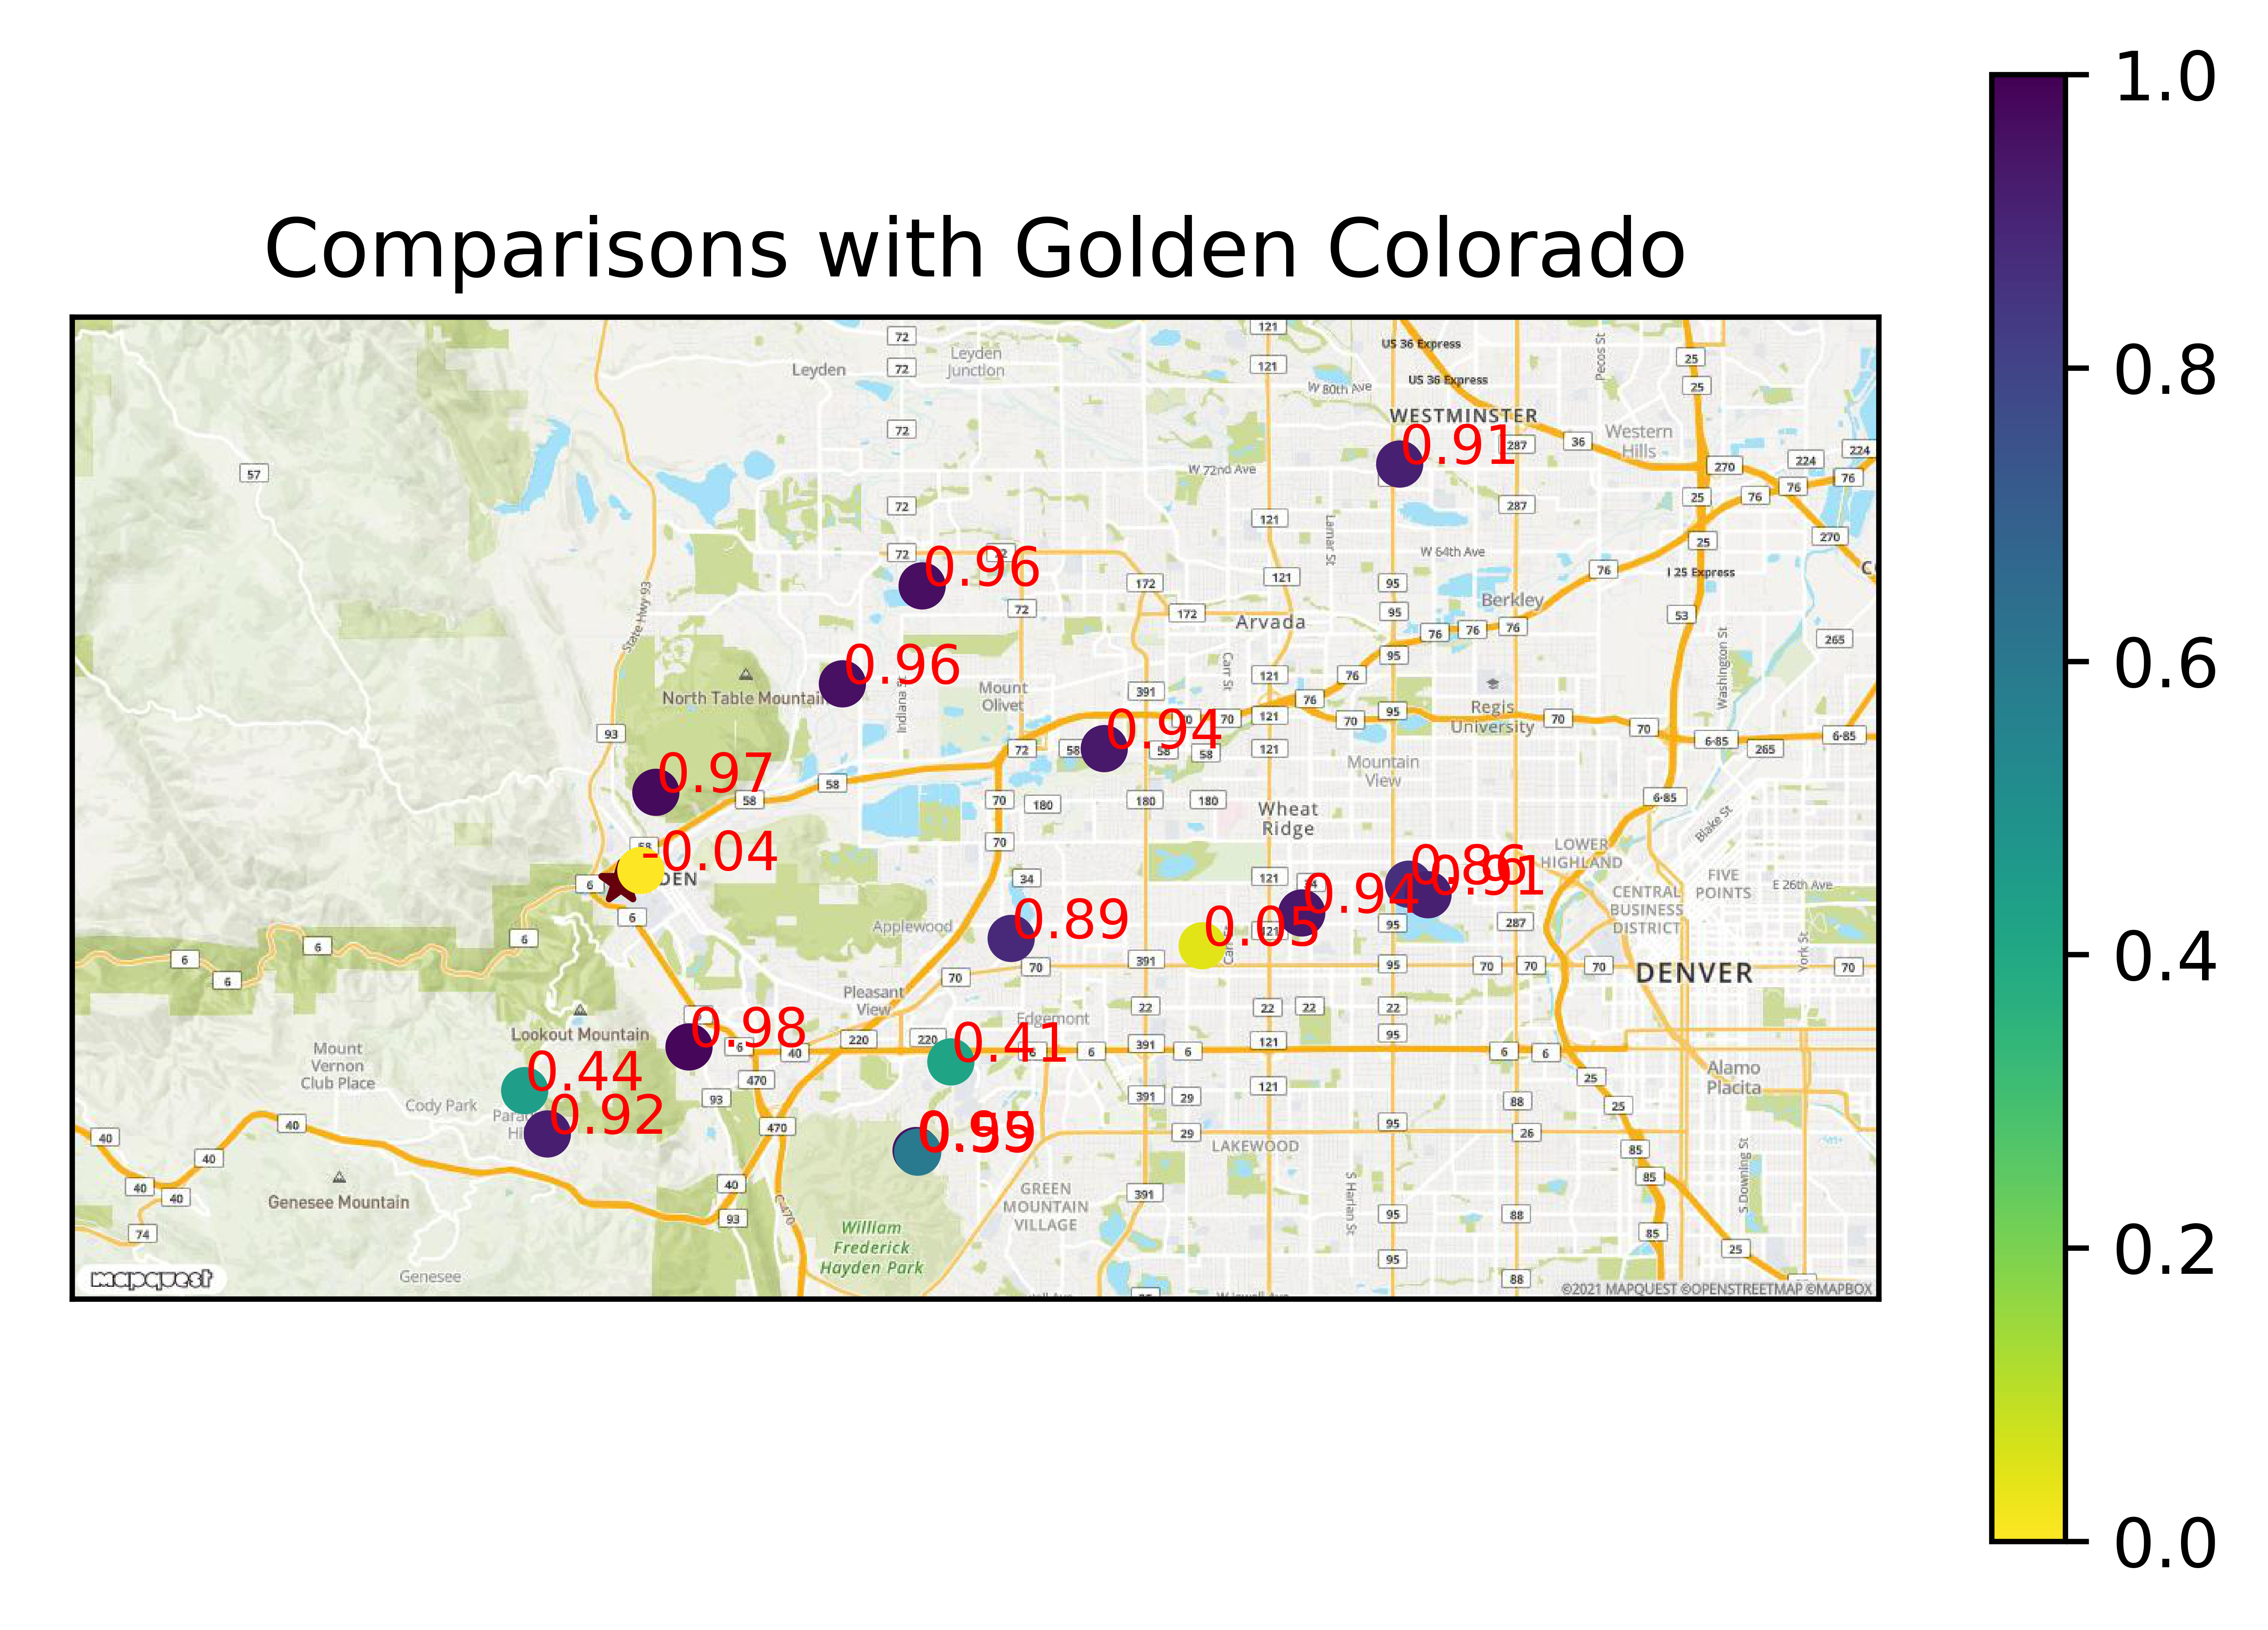

In [3]:
image = ds.load_img(data, new=False)

color_map = plt.cm.get_cmap('viridis').reversed()
plt.figure(dpi=1200)
plt.imshow(image, cmap=color_map)
plt.clim(0, 1)
plt.colorbar()

reference_location = "Golden Colorado"
for location in np.unique(data["location"]):
    selected_df = data[data["location"] == location]
    lat = selected_df["lat"].iloc[0]
    long = selected_df["long"].iloc[0]

    min_lat = np.min(data["lat"])
    max_lat = np.max(data["lat"])
    min_long = np.min(data["long"])
    max_long = np.max(data["long"])

    width = image.size[0]
    long = width * (long - min_long) / (max_long - min_long)

    height = image.size[1]
    lat = height - height * (lat - min_lat) / (max_lat - min_lat)

    # Scale. This is a rough fix for the weird issues that mapquest has with their API
    lat = int(0.7 * (lat - height / 2) + height / 2)
    long = int(0.5 * (long - width / 2) + width / 2)

    rmse = ana.get_rmse(data, reference_location, location) / 170  # TODO Make this dynamic
    if location == reference_location:
        color = cm.Reds(1.0)
        plt.scatter(long, lat, c=[color], marker="*")
    else:
        corr = ana.get_cor(data, reference_location, location)
        if np.isnan(corr):
            continue
        color = color_map(corr)
        plt.text(long, lat, str(round(corr, 2)), color="red", fontsize=8)
        plt.scatter(long, lat, c=[color])


plt.title("Comparisons with " + reference_location)
plt.xticks([])
plt.yticks([])
plt.savefig("output.png")
plt.show()


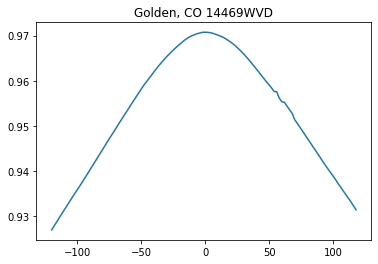

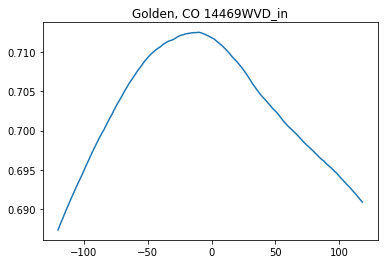

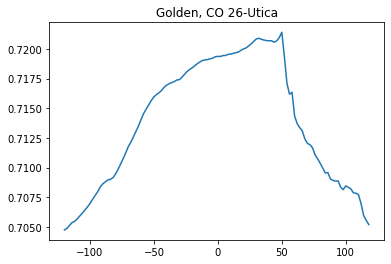

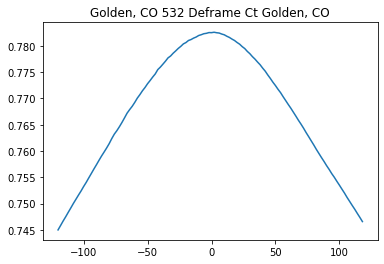

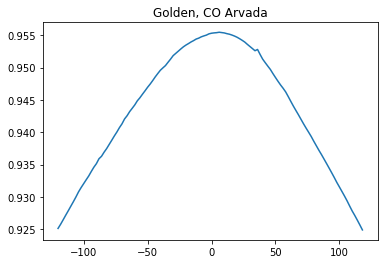

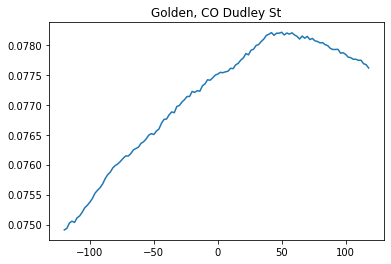

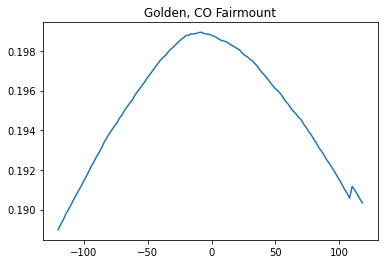

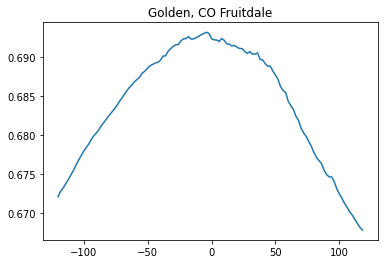

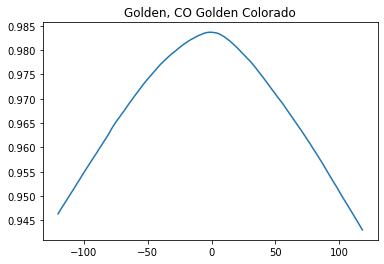

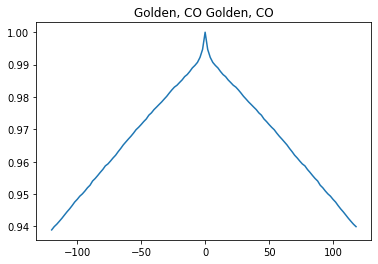

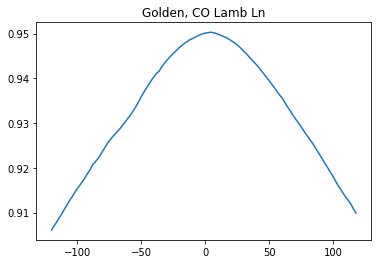

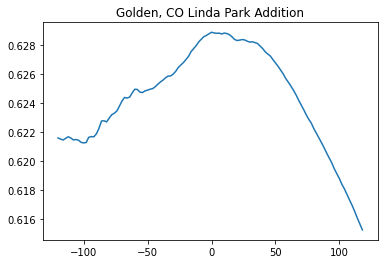

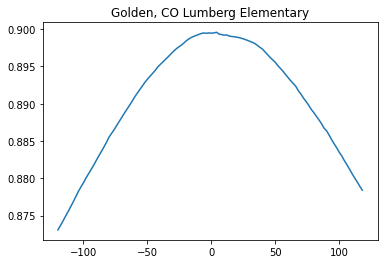

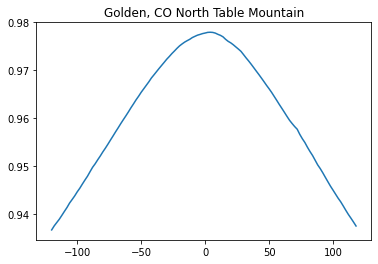

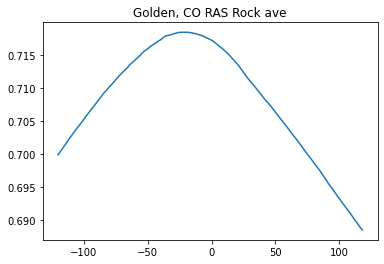

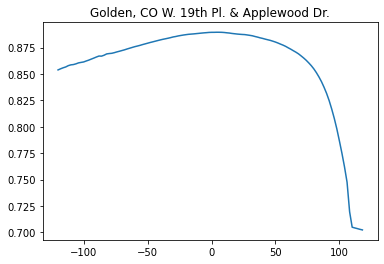

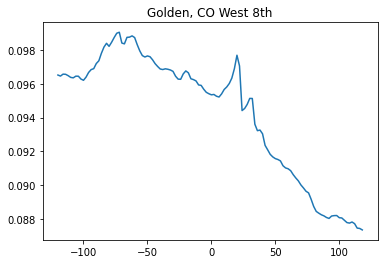

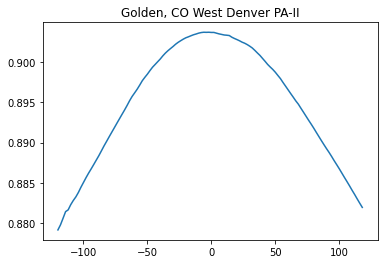

In [6]:
def get_corr(data, recalculate=False):
    if not recalculate:
        with open("corr.pkl", "rb") as fp:
            differences =  pickle.load(fp)
        with open("lags.pkl", "rb") as fp:
            lags =  pickle.load(fp)
        return differences, lags

    all_differences = []
    all_lags = []
    for reference_location in np.unique(data["location"]):
        reference_df = data[data["location"] == reference_location]
        best_differences = []
        lags = []
        for location in np.unique(data["location"]):
            selected_df = data[data["location"] == location]
            
            difference_list = []
            for difference in range(-120, 120, 2):
                selected_df_copy = selected_df.copy(deep=True)
                selected_df_copy[gv.date_name] = selected_df_copy[gv.date_name] + pd.Timedelta(difference, "m")
                
                corr = ana.get_cor_df(reference_df, selected_df_copy)
                difference_list.append(corr)

            if reference_location == "Golden, CO":
                plt.title(reference_location + " " + location)
                plt.plot(range(-120, 120, 2), difference_list)
                plt.show()
                
            best_diff = np.min(difference_list)
            if np.isnan(best_diff):
                print(location)
            best_differences.append(best_diff)
            lag = difference_list.index(best_diff) - 60
            lags.append(lag)

        all_differences.append(best_differences)
        all_lags.append(lags)


    with open("corr.pkl", "wb") as fp:
        pickle.dump(all_differences, fp)

    with open("lags.pkl", "wb") as fp:
        pickle.dump(all_differences, fp)
        
    return all_differences, all_lags


all_differences, all_lags = get_corr(data, recalculate=True)

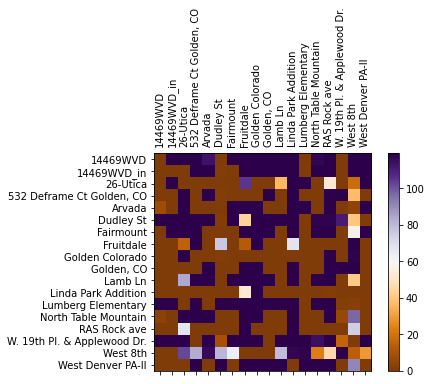

In [17]:
plt.imshow(all_lags, cmap='PuOr')
plt.colorbar()
plt.tick_params(labelbottom=False, labeltop=True)
plt.xticks(range(len(np.unique(data["location"]))), np.unique(data["location"]), rotation=90)
plt.yticks(range(len(np.unique(data["location"]))), np.unique(data["location"]))
plt.show()

In [18]:
for x in all_lags:
    print(x)

[0, 119, 119, 119, 113, 0, 119, 119, 119, 119, 119, 119, 0, 117, 119, 0, 119, 119]
[0, 0, 0, 119, 119, 1, 0, 119, 119, 119, 119, 119, 0, 119, 119, 0, 119, 119]
[0, 119, 0, 0, 0, 0, 0, 105, 0, 0, 36, 119, 119, 0, 53, 0, 18, 119]
[0, 0, 119, 0, 119, 1, 0, 0, 0, 119, 0, 119, 0, 0, 119, 119, 37, 0]
[7, 0, 119, 0, 0, 0, 119, 119, 119, 0, 0, 119, 119, 0, 119, 0, 4, 119]
[119, 119, 119, 119, 119, 1, 119, 44, 119, 119, 119, 119, 0, 118, 118, 111, 40, 0]
[0, 119, 119, 119, 0, 0, 0, 119, 119, 119, 0, 119, 0, 119, 119, 0, 57, 119]
[0, 0, 15, 119, 0, 76, 0, 13, 119, 0, 0, 67, 0, 0, 0, 0, 119, 0]
[0, 0, 119, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 119, 0, 118, 0]
[0, 0, 0, 0, 119, 0, 0, 119, 119, 0, 0, 119, 0, 0, 119, 119, 119, 0]
[0, 0, 84, 119, 119, 0, 119, 119, 119, 119, 0, 119, 0, 119, 119, 0, 41, 0]
[0, 0, 0, 0, 0, 0, 0, 53, 119, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[119, 119, 0, 119, 0, 119, 119, 119, 119, 119, 119, 119, 0, 119, 119, 1, 2, 0]
[3, 0, 119, 119, 119, 0, 0, 119, 119, 0, 0, 119, 0, 0, 119, 6, 97, 

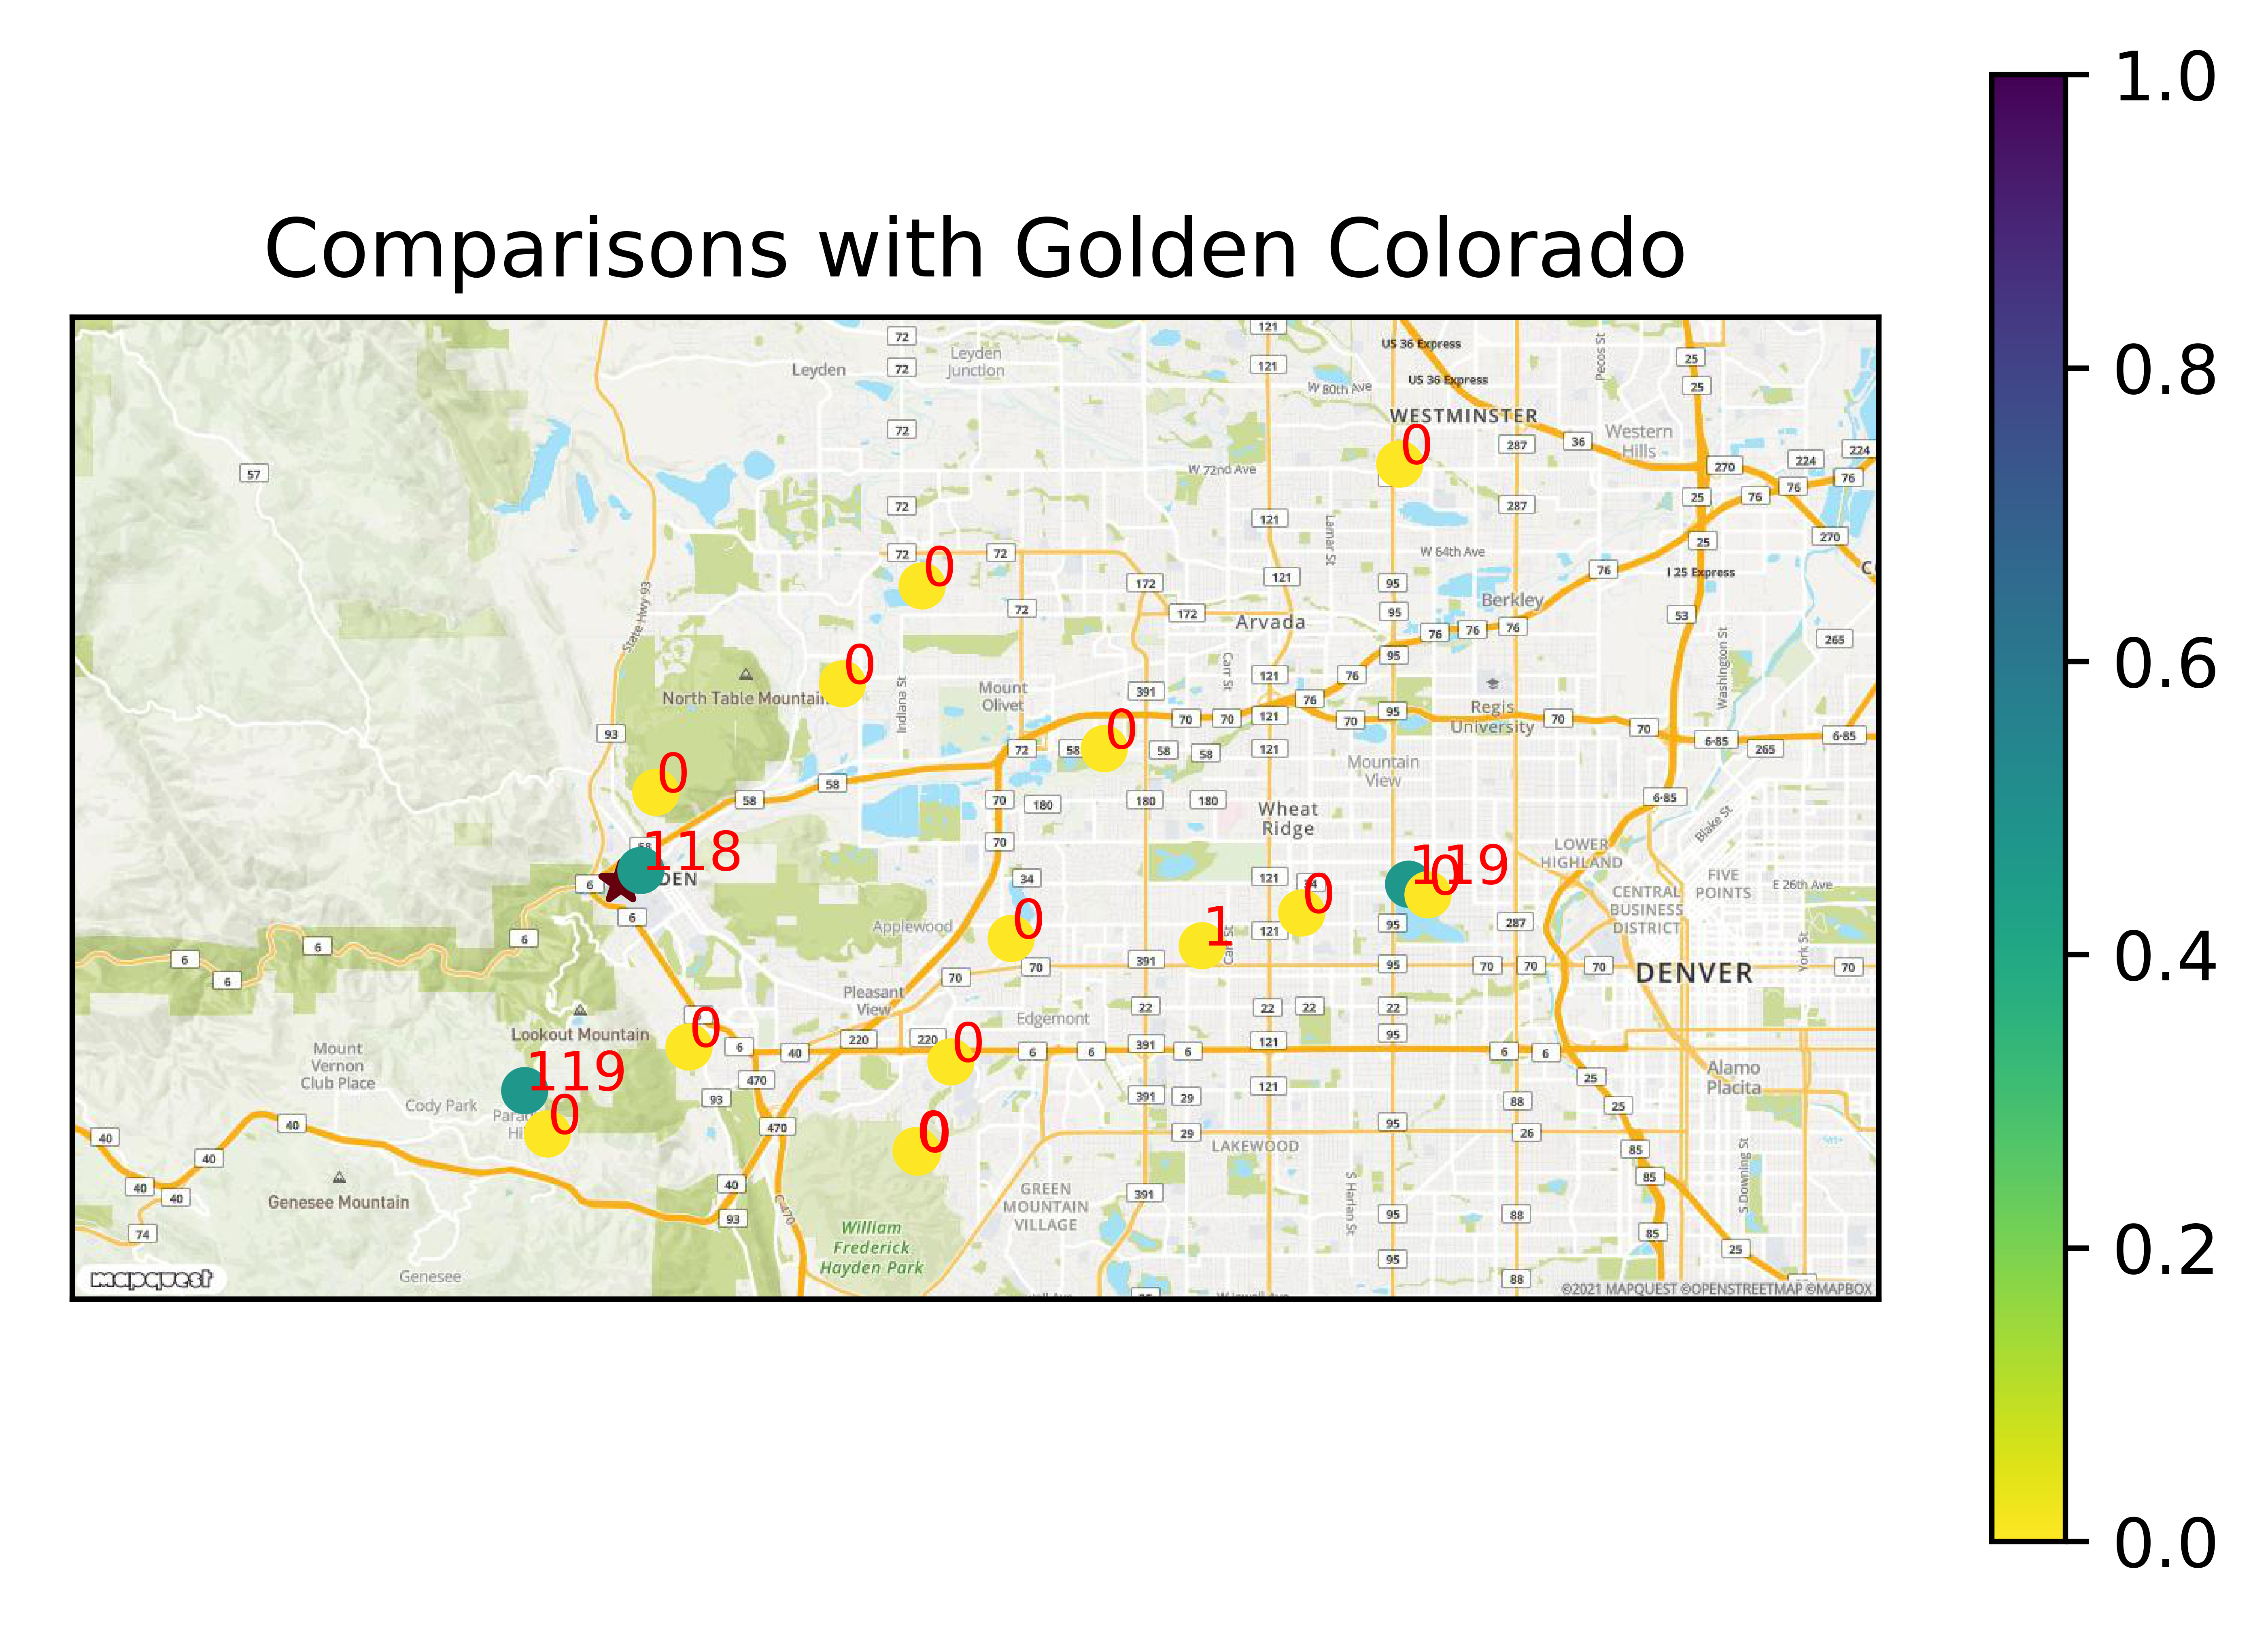

In [10]:
image = ds.load_img(data, new=False)

color_map = plt.cm.get_cmap('viridis').reversed()
plt.figure(dpi=1200)
plt.imshow(image, cmap=color_map)
plt.clim(0, 1)
plt.colorbar()

reference_location = "Golden Colorado"
for location in np.unique(data["location"]):
    selected_df = data[data["location"] == location]
    lat = selected_df["lat"].iloc[0]
    long = selected_df["long"].iloc[0]

    min_lat = np.min(data["lat"])
    max_lat = np.max(data["lat"])
    min_long = np.min(data["long"])
    max_long = np.max(data["long"])

    width = image.size[0]
    long = width * (long - min_long) / (max_long - min_long)

    height = image.size[1]
    lat = height - height * (lat - min_lat) / (max_lat - min_lat)

    lat = int(0.7 * (lat - height / 2) + height / 2)
    long = int(0.5 * (long - width / 2) + width / 2)

    rmse = ana.get_rmse(data, reference_location, location) / 170  # TODO Make this dynamic
    if location == reference_location:
        color = cm.Reds(1.0)
        plt.scatter(long, lat, c=[color], marker="*")
    else:
        reference_index = np.where(np.unique(data["location"]) == reference_location)[0][0]
        new_index = np.where(np.unique(data["location"]) == location)[0][0]
        corr = all_lags[reference_index][new_index]
        if np.isnan(corr):
            continue
        color = color_map(corr)
        plt.text(long, lat, str(round(corr, 2)), color="red", fontsize=8)
        plt.scatter(long, lat, c=[color])


plt.title("Comparisons with " + reference_location)
plt.xticks([])
plt.yticks([])
plt.savefig("output.png")
plt.show()